In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torchvision scikit-learn seaborn

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# ================================
# 🔹 DATA DIR - MÁSCARAS
# ================================
data_dir = "/content/drive/MyDrive/PigRGB-Weight/RGB_9579"

print("="*60)
print("📁 CARREGANDO IMAGENS SEGMENTADAS")
print("="*60)

image_paths = []
weights = []
pesos_unicos = []
imagens_por_peso = {}

# ================================
# 🔹 LOOP PRINCIPAL - 2 NÍVEIS (fold -> peso)
# ================================
for fold_folder in tqdm(os.listdir(data_dir), desc="Processando folds"):
    fold_path = os.path.join(data_dir, fold_folder)

    # Pula se não for diretório
    if not os.path.isdir(fold_path):
        continue

    print(f"\n📂 Processando {fold_folder}...")

    # Dentro de cada fold, procura as pastas de peso
    for weight_folder in os.listdir(fold_path):
        weight_path = os.path.join(fold_path, weight_folder)

        if not os.path.isdir(weight_path):
            continue

        # Extrai o peso do nome da pasta (ex: "33.64_36" -> 33.64)
        try:
            peso_str = weight_folder.split("_")[0]
            weight_value = float(peso_str)
            if weight_value not in pesos_unicos:
                pesos_unicos.append(weight_value)
        except (ValueError, IndexError):
            print(f"   ⚠️ Pasta ignorada (formato inválido): {weight_folder}")
            continue

        # Contador para estatísticas
        img_count = 0

        # Lista todas as imagens na pasta
        for img_file in os.listdir(weight_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(weight_path, img_file))
                weights.append(weight_value)
                img_count += 1

        # Armazena estatísticas
        if img_count > 0:
            imagens_por_peso[f"{fold_folder}/{weight_folder}"] = img_count
            print(f"   ✅ {weight_folder}: {img_count} imagens")

# ================================
# 🔹 VERIFICA SE ENCONTROU IMAGENS
# ================================
if len(image_paths) == 0:
    print("\n❌ ERRO: Nenhuma imagem encontrada!")
    print("\n📁 Conteúdo do diretório:")
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        tipo = "📁 PASTA" if os.path.isdir(item_path) else "📄 ARQUIVO"
        print(f"   {tipo}: {item}")
    exit()

# ================================
# 🔹 ESTATÍSTICAS DETALHADAS
# ================================
print("\n" + "="*60)
print("📊 ESTATÍSTICAS DO DATASET")
print("="*60)

print(f"\n✅ TOTAL DE IMAGENS: {len(image_paths)}")
print(f"✅ TOTAL DE PASTAS DE PESO: {len(imagens_por_peso)}")
print(f"✅ TOTAL DE PESOS ÚNICOS: {len(pesos_unicos)}")

print(f"\n📊 DISTRIBUIÇÃO DE IMAGENS POR PESO:")
print(f"   Média: {np.mean(list(imagens_por_peso.values())):.1f} imagens/pasta")
print(f"   Mínimo: {min(imagens_por_peso.values())} imagens")
print(f"   Máximo: {max(imagens_por_peso.values())} imagens")

print(f"\n📊 ANÁLISE DOS PESOS:")
print(f"   Mínimo: {min(weights):.2f} kg")
print(f"   Máximo: {max(weights):.2f} kg")
print(f"   Média: {np.mean(weights):.2f} kg")
print(f"   Mediana: {np.median(weights):.2f} kg")
print(f"   Desvio padrão: {np.std(weights):.2f} kg")

print(f"\n📂 EXEMPLO DE CAMINHOS:")
for i in range(min(3, len(image_paths))):
    path_parts = image_paths[i].split(os.sep)
    # Mostra caminho relativo a partir de RGB_9579
    rel_path = os.path.join(*path_parts[-4:])
    print(f"   {i+1}. {rel_path} -> {weights[i]:.2f} kg")

# ================================
# 🔹 DIVISÃO TREINO/VALIDAÇÃO (ESTRATIFICADA)
# ================================
print("\n" + "="*60)
print("🔀 DIVIDINDO TREINO E VALIDAÇÃO")
print("="*60)

# Cria faixas de peso para estratificação (intervalos de 10kg)
pesos_array = np.array(weights)
faixas = (pesos_array // 10).astype(int)

train_paths, val_paths, train_weights, val_weights = train_test_split(
    image_paths,
    weights,
    test_size=0.2,
    random_state=42,
    stratify=faixas,
    shuffle=True
)

print(f"\n✅ TREINO: {len(train_paths)} imagens")
print(f"✅ VALIDAÇÃO: {len(val_paths)} imagens")
print(f"\n📊 Distribuição dos pesos - Treino:")
print(f"   Mínimo: {min(train_weights):.2f} kg")
print(f"   Máximo: {max(train_weights):.2f} kg")
print(f"   Média: {np.mean(train_weights):.2f} kg")

print(f"\n📊 Distribuição dos pesos - Validação:")
print(f"   Mínimo: {min(val_weights):.2f} kg")
print(f"   Máximo: {max(val_weights):.2f} kg")
print(f"   Média: {np.mean(val_weights):.2f} kg")

print("\n" + "="*60)
print("🎯 DATASET CARREGADO COM SUCESSO!")
print("="*60)

📁 CARREGANDO IMAGENS SEGMENTADAS (MÁSCARAS)


Processando folds:   0%|          | 0/5 [00:00<?, ?it/s]


📂 Processando fold4...
   ✅ 87.85_143: 143 imagens
   ✅ 83.8_138: 138 imagens
   ✅ 98.7_134: 134 imagens
   ✅ 93.89_130: 130 imagens
   ✅ 127.3_117: 117 imagens
   ✅ 167.8_106: 106 imagens
   ✅ 101.7_123: 123 imagens
   ✅ 112.71_122: 122 imagens
   ✅ 104.04_130: 130 imagens
   ✅ 182.28_118: 118 imagens
   ✅ 156.56_135: 135 imagens
   ✅ 109.24_135: 135 imagens
   ✅ 146.3_141: 141 imagens
   ✅ 137.56_135: 135 imagens

📂 Processando fold2...
   ✅ 74.4_125: 125 imagens
   ✅ 97.7_133: 133 imagens
   ✅ 92.2_127: 127 imagens
   ✅ 87.3_260: 260 imagens
   ✅ 99.43_139: 139 imagens
   ✅ 192.39_122: 122 imagens
   ✅ 160.4_103: 103 imagens
   ✅ 124.4_123: 123 imagens
   ✅ 112.29_106: 106 imagens
   ✅ 105.98_134: 134 imagens
   ✅ 153.44_141: 141 imagens
   ✅ 101.98_137: 137 imagens
   ✅ 145.2_142: 142 imagens
   ✅ 129.56_146: 146 imagens
   ✅ 180.47_92: 92 imagens

📂 Processando fold3...
   ✅ 98.6_139: 139 imagens
   ✅ 165.6_106: 106 imagens
   ✅ 155.64_110: 110 imagens
   ✅ 192.48_103: 103 imagen

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class PigDataset(Dataset):
    def __init__(self, image_paths, weights_normalized, transform=None):
        self.image_paths = image_paths
        #self.weights = weights
        self.weights = weights_normalized
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        weight = self.weights[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(weight, dtype=torch.float32)


In [5]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

# ================================
# 🔹 TRANSFORMS
# ================================

# Transform para TREINO (com augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224,224)),          # 🔥 diminuir imagem = treino mais rápido
    transforms.RandomHorizontalFlip(),     # augmentation ajuda generalização
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 🔥
    transforms.ToTensor(),
    transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    )
])

# Transform para VALIDAÇÃO (SEM augmentation!)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ================================
# 🔹 DATASETS
# ================================

train_dataset = PigDataset(train_paths, train_weights, train_transform)
val_dataset = PigDataset(val_paths, val_weights, val_transform)

# ================================
# 🔹 MODO HACKATHON (LIMITAR IMAGENS)
# ================================

HACKATHON_MODE = False   # ⬅️ MUDE PARA False quando quiser usar dataset completo

if HACKATHON_MODE:
    train_limit = 3000   # 🔥 pode testar 300, 600, 800
    val_limit = 400

    train_indices = torch.randperm(len(train_dataset))[:train_limit]
    val_indices = torch.randperm(len(val_dataset))[:val_limit]

    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)

# ================================
# 🔹 DATALOADERS
# ================================

train_loader = DataLoader(
    train_dataset,
    batch_size=64,   # 🔥 maior batch = mais rápido (se GPU permitir)
    shuffle=True,
    num_workers=2,   # melhora velocidade de carregamento
    pin_memory=True  # melhora performance em GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [6]:
import torchvision.models as models
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s]


In [7]:
from tqdm.notebook import tqdm  # para Colab/Jupyter
# se for script .py normal use: from tqdm import tqdm

epochs = 50

train_losses = []
val_losses = []
history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0

    # Barra de progresso no treino
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

    for images, weights_batch in train_bar:
        images = images.to(device)
        weights_batch = weights_batch.unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, weights_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Atualiza info da barra
        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ===== VALIDAÇÃO =====
    model.eval()
    val_loss = 0


    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)

    with torch.no_grad():
        for images, weights_batch in val_bar:
            images = images.to(device)
            weights_batch = weights_batch.unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, weights_batch)
            val_loss += loss.item()

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.3f} | Val: {val_loss:.3f}")
    history.append((epoch+1, train_loss, val_loss))

    from IPython.display import clear_output
    clear_output(wait=True)

    for e, t, v in history:
        print(f"Epoch {e} | Train: {t:.3f} | Val: {v:.3f}")


Epoch 1 | Train: 12937.439 | Val: 12592.182
Epoch 2 | Train: 7909.083 | Val: 5104.968
Epoch 3 | Train: 3524.278 | Val: 2220.504
Epoch 4 | Train: 1137.745 | Val: 381.904
Epoch 5 | Train: 278.133 | Val: 149.052
Epoch 6 | Train: 74.680 | Val: 47.390
Epoch 7 | Train: 52.709 | Val: 35.347
Epoch 8 | Train: 39.614 | Val: 24.027
Epoch 9 | Train: 37.469 | Val: 22.224
Epoch 10 | Train: 32.526 | Val: 20.422
Epoch 11 | Train: 31.640 | Val: 30.979
Epoch 12 | Train: 30.541 | Val: 22.933
Epoch 13 | Train: 25.152 | Val: 17.878
Epoch 14 | Train: 28.281 | Val: 50.015
Epoch 15 | Train: 25.887 | Val: 35.916
Epoch 16 | Train: 22.888 | Val: 18.210
Epoch 17 | Train: 23.839 | Val: 15.261
Epoch 18 | Train: 19.467 | Val: 27.966
Epoch 19 | Train: 18.070 | Val: 20.131
Epoch 20 | Train: 23.367 | Val: 14.192
Epoch 21 | Train: 16.552 | Val: 15.297
Epoch 22 | Train: 17.245 | Val: 22.574
Epoch 23 | Train: 13.465 | Val: 17.815
Epoch 24 | Train: 15.919 | Val: 23.426
Epoch 25 | Train: 13.297 | Val: 14.142
Epoch 26 | Trai

In [8]:
import torch

torch.save(model.state_dict(), "/content/drive/MyDrive/50modelo_peso_suinoOriginal.pth")
print("Modelo salvo com sucesso!")


Modelo salvo com sucesso!


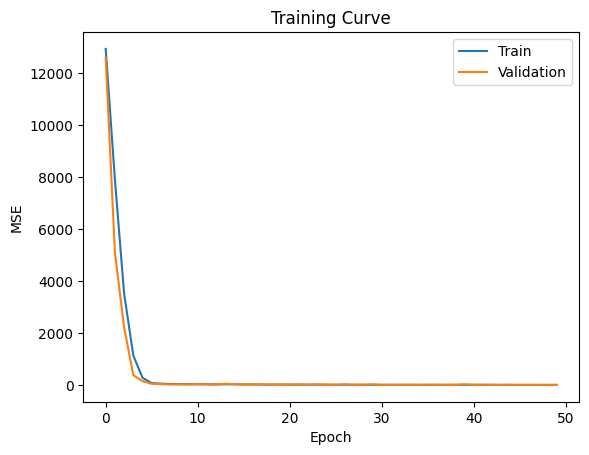

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training Curve")
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error
import numpy as np

model.eval()
preds = []
reals = []

with torch.no_grad():
    for images, weights_batch in val_loader:
        images = images.to(device)
        outputs = model(images)

        preds.extend(outputs.cpu().numpy().flatten())
        reals.extend(weights_batch.numpy())

mae = mean_absolute_error(reals, preds)
print(f"MAE: {mae:.2f} kg")


MAE: 1.72 kg


In [11]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("/content/drive/MyDrive/50modelo_peso_suinoOriginal.pth", map_location=device))
model = model.to(device)
model.eval()

print("Modelo carregado com sucesso!")


Modelo carregado com sucesso!


Saving 101.74kg_12.png to 101.74kg_12.png


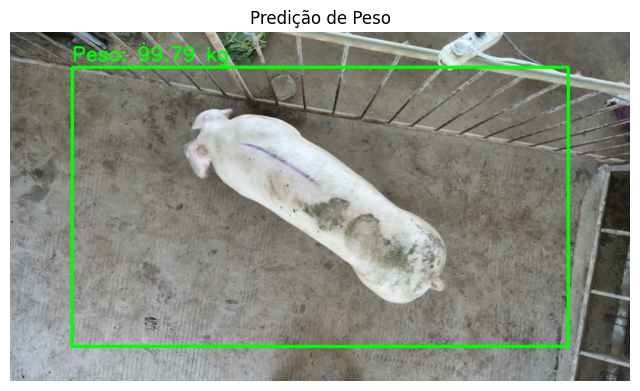

In [18]:
import torch
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from google.colab import files

# definir device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# upload da imagem
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# transformação igual treino
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# carregar imagem original (para desenhar depois)
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# carregar versão para predição
pil_image = Image.open(image_path).convert("RGB")
image = transform(pil_image)
image = image.unsqueeze(0).to(device)

# previsão
model.eval()
with torch.no_grad():
    prediction = model(image)

peso_previsto = prediction.item()

# -------------------------
# ANOTAÇÃO DA IMAGEM
# -------------------------

h, w, _ = original_image.shape

# exemplo: desenhar caixa central (caso não tenha detector)
x1, y1 = int(w*0.1), int(h*0.1)
x2, y2 = int(w*0.9), int(h*0.9)

cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 3)

texto = f"Peso: {peso_previsto:.2f} kg"

cv2.putText(
    original_image,
    texto,
    (x1, y1 - 10),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    (0, 255, 0),
    2,
    cv2.LINE_AA
)

# mostrar imagem
plt.figure(figsize=(8,8))
plt.imshow(original_image)
plt.axis("off")
plt.title("Predição de Peso")
plt.show()


Saving 87.3kg_2.png to 87.3kg_2.png


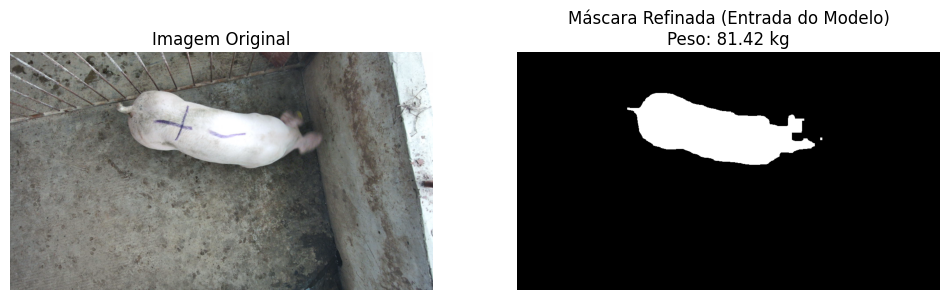

True

In [15]:
import torch
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import matplotlib.pyplot as plt
from google.colab import files

# --- 1. CONFIGURAÇÕES ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights_seg = DeepLabV3_ResNet50_Weights.DEFAULT
model_seg = deeplabv3_resnet50(weights=weights_seg).to(device).eval()

# model.to(device).eval() # Seu modelo de peso já deve estar carregado

# --- 2. UPLOAD E CRIAÇÃO DA MÁSCARA REFINADA ---
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img_pil = Image.open(image_path).convert("RGB")

preprocess_seg = weights_seg.transforms()
input_seg = preprocess_seg(img_pil).unsqueeze(0).to(device)

with torch.no_grad():
    output_seg = model_seg(input_seg)['out'][0]
    mask_indices = output_seg.argmax(0)
    mask_np = (mask_indices > 0).byte().cpu().numpy().astype(np.uint8) * 255

    # --- AJUSTE MORFOLÓGICO (LIMPEZA) ---
    # Kernel define a força da limpeza. (5,5) para ruído, (15,15) para buracos.
    kernel_noise = np.ones((5, 5), np.uint8)
    kernel_holes = np.ones((15, 15), np.uint8)

    # 1. Remove pontinhos brancos pequenos no fundo (Opening)
    mask_cleaned = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel_noise)
    # 2. Fecha buracos pretos dentro do porco (Closing)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel_holes)

    # Redimensiona para o tamanho original
    mask_resized = cv2.resize(mask_cleaned, (img_pil.width, img_pil.height), interpolation=cv2.INTER_NEAREST)

# --- 3. PREPARAÇÃO DA MÁSCARA PARA O MODELO DE PESO ---
# Transformamos a máscara em RGB para o modelo de peso
mask_rgb = cv2.cvtColor(mask_resized, cv2.COLOR_GRAY2RGB)
mask_pil = Image.fromarray(mask_rgb)

transform_peso = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_final_peso = transform_peso(mask_pil).unsqueeze(0).to(device)

# --- 4. PREDIÇÃO DO PESO ---
with torch.no_grad():
    prediction = model(input_final_peso)
    peso_previsto = prediction.item()

# --- 5. VISUALIZAÇÃO ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title("Imagem Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_resized, cmap='gray')
plt.title(f"Máscara Refinada (Entrada do Modelo)\nPeso: {peso_previsto:.2f} kg")
plt.axis("off")

plt.show()

cv2.imwrite("mascara_limpa.png", mask_resized)

Usando device: cuda
Faça upload de todas as imagens de teste (peso no nome)


Saving 95.52kg_5.png to 95.52kg_5 (2).png
Saving 182.28kg_3.png to 182.28kg_3 (2).png
Saving 167.8kg_3.png to 167.8kg_3 (2).png
Saving 137.56kg_3.png to 137.56kg_3 (2).png
Saving 146.3kg_1.png to 146.3kg_1 (2).png
Saving 101.74kg_11.png to 101.74kg_11 (2).png
Saving 178.54kg_1.png to 178.54kg_1 (3).png
Saving 112.7kg_8.png to 112.7kg_8 (4).png
Saving 73.36kg_4.png to 73.36kg_4 (2).png
Saving 97.7kg_1.png to 97.7kg_1 (3).png
Saving 87.3kg_2.png to 87.3kg_2 (5).png
Pesos extraídos: [ 95.52 182.28 167.8  137.56 146.3  101.74 178.54 112.7   73.36  97.7
  87.3 ]
Modelos carregados!


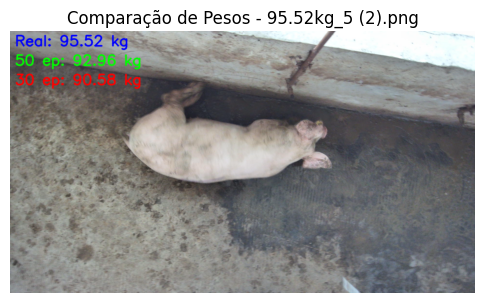

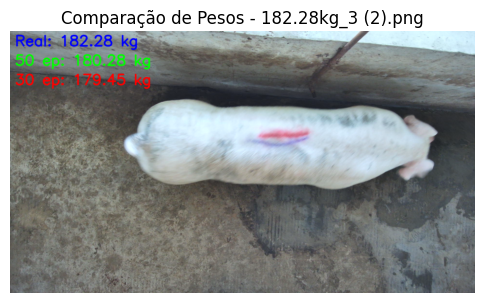

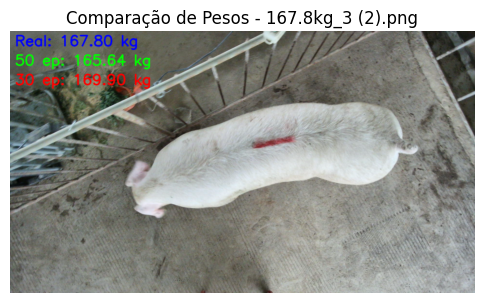

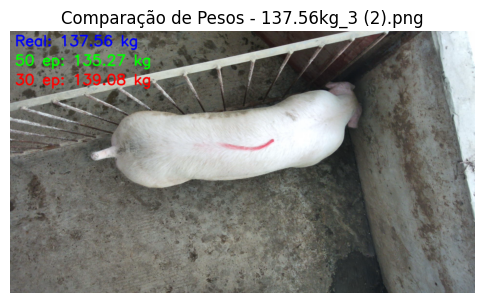

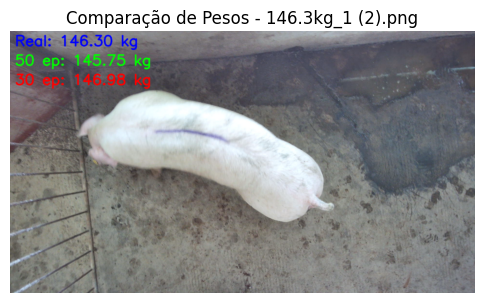

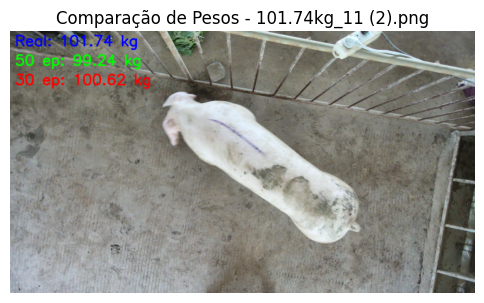

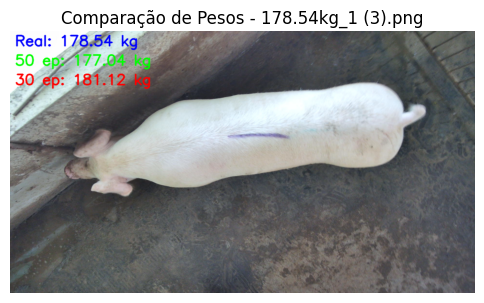

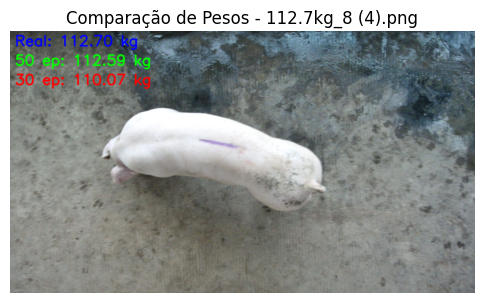

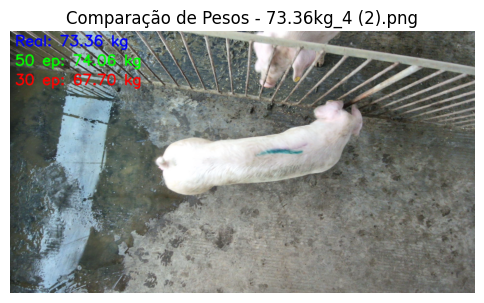

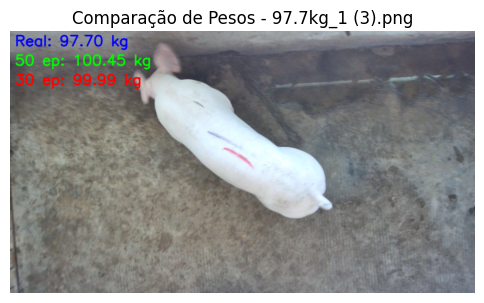

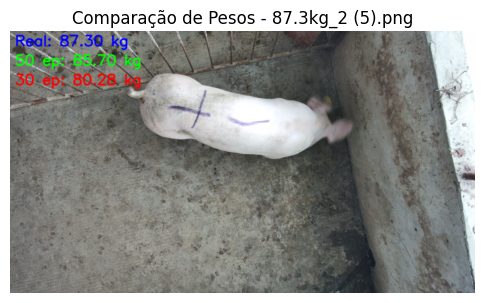


Tabela comparativa dos modelos:


Imagem  Peso Real (kg)  Modelo 50 ep (kg)  Modelo 30 ep (kg)  \
0     95.52kg_5 (2).png           95.52              92.96              90.58   
1    182.28kg_3 (2).png          182.28             180.28             179.45   
2     167.8kg_3 (2).png          167.80             165.64             169.90   
3    137.56kg_3 (2).png          137.56             135.27             139.08   
4     146.3kg_1 (2).png          146.30             145.75             146.98   
5   101.74kg_11 (2).png          101.74              99.24             100.62   
6    178.54kg_1 (3).png          178.54             177.04             181.12   
7     112.7kg_8 (4).png          112.70             112.59             110.07   
8     73.36kg_4 (2).png           73.36              74.06              67.70   
9      97.7kg_1 (3).png           97.70             100.45              99.99   
10     87.3kg_2 (5).png           87.30              85.70              80.28   

    Dif. 50ep-Real  Dif. 30ep-Real  
0             2.56            4.94  
1             2.00            2.83  
2             2.16            2.10  
3             2.29            1.52  
4             0.55            0.68  
5             2.50            1.12  
6             1.50            2.58  
7             0.11            2.63  
8             0.70            5.66  
9             2.75            2.29  
10            1.60            7.02

In [21]:
# ---------------------------------
# COMPARAÇÃO VISUAL E TABELA DE MODELOS DE PESO DE SUÍNOS
# ---------------------------------

import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import re
import cv2
import os
import pandas as pd

# 1️⃣ Configurar device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# 2️⃣ Transformação igual ao treino
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 3️⃣ Função para carregar modelo
def load_model(path):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# 4️⃣ Função para prever
def predict(model, image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        y = model(x)
    return y.item()

# 5️⃣ Upload das imagens
print("Faça upload de todas as imagens de teste (peso no nome)")
uploaded = files.upload()
test_images = list(uploaded.keys())

# 6️⃣ Extrair pesos reais do nome do arquivo
test_weights = []
for fname in test_images:
    match = re.search(r'([\d\.]+)kg', fname)
    if match:
        test_weights.append(float(match.group(1)))
    else:
        raise ValueError(f"Não foi possível extrair peso do arquivo: {fname}")
test_weights = np.array(test_weights)
print("Pesos extraídos:", test_weights)

# 7️⃣ Carregar modelos
model1 = load_model("/content/drive/MyDrive/50modelo_peso_suinoOriginal.pth")  # 50 épocas
model2 = load_model("/content/drive/MyDrive/modelo_peso_suino.pth")           # 30 épocas
print("Modelos carregados!")

# 8️⃣ Preparar lista para tabela
tabela = []

# 9️⃣ Previsões e visualização
for idx, img_path in enumerate(test_images):
    peso_real = test_weights[idx]
    peso_model1 = predict(model1, img_path)
    peso_model2 = predict(model2, img_path)

    # Adicionar linha à tabela
    tabela.append({
        "Imagem": os.path.basename(img_path),
        "Peso Real (kg)": peso_real,
        "Modelo 50 ep (kg)": peso_model1,
        "Modelo 30 ep (kg)": peso_model2,
        "Dif. 50ep-Real": abs(peso_model1 - peso_real),
        "Dif. 30ep-Real": abs(peso_model2 - peso_real)
    })

    # Visualização da imagem com pesos
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    texto_real = f"Real: {peso_real:.2f} kg"
    texto_m1 = f"50 ep: {peso_model1:.2f} kg"
    texto_m2 = f"30 ep: {peso_model2:.2f} kg"

    cv2.putText(img_cv, texto_real, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    cv2.putText(img_cv, texto_m1, (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    cv2.putText(img_cv, texto_m2, (10,110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)

    plt.figure(figsize=(6,6))
    plt.imshow(img_cv)
    plt.axis('off')
    plt.title(f"Comparação de Pesos - {os.path.basename(img_path)}")
    plt.show()

# 10️⃣ Criar DataFrame da tabela
df_tabela = pd.DataFrame(tabela)

# 11️⃣ Mostrar tabela completa
pd.set_option('display.float_format', '{:.2f}'.format)
print("\nTabela comparativa dos modelos:")
display(df_tabela)
